In [6]:
import drawsvg as draw
import operator

(0.0, 200.0, 400.0, 0.0) (20.0, 190.0, 370.0, 50.0)


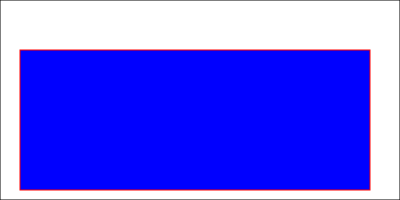

In [23]:
class TRF:
    def __init__(self, x0, x1, xn0, xn1):
        self.x0 = x0
        self.x1 = x1
        self.xn0 = xn0
        self.xn1 = xn1

    def o2n(self, x):
        return self.xn0 + (x - self.x0) / (self.x1 - self.x0) * (self.xn1 - self.xn0)
    
    def n2o(self, xn):
        return self.x0 + (xn - self.xn0) / (self.xn1 - self.xn0) * (self.x1 - self.x0)
    
    # define add for TRF:
    def __add__(self, other):
        return TRF(self.x0, self.x1, self.xn0 + other.xn0, self.xn1 + other.xn1)
    
class SPlotter:
    def __init__(self, size, border=None, rect=None, pixel_scale=1.0):
        self.size = size
        self.trf_xph = TRF(0, size[0], 0, size[0])
        self.trf_yph = TRF(0, size[1], size[1], 0)

        self.canvas = draw.Drawing(size[0], size[1], origin=(0,0))
        self.pixel_scale = pixel_scale
        self.canvas.set_pixel_scale(pixel_scale)

        self.canvas_area = (self.trf_xph.o2n(0), self.trf_yph.o2n(0), self.trf_xph.o2n(size[0]), self.trf_yph.o2n(size[1]))
        self.border = border
                            
        self.plot_area = (self.canvas_area[0] + self.border[0], self.canvas_area[1] - self.border[1], self.canvas_area[2] - self.border[2], self.canvas_area[3] + self.border[3])

sp = SPlotter(size=(400,200), border=(20,10,30,50))
print(sp.canvas_area, sp.plot_area)
sp.canvas.append(draw.Rectangle(sp.canvas_area[0], sp.canvas_area[3], sp.canvas_area[2]-sp.canvas_area[0], -sp.canvas_area[3]+sp.canvas_area[1], fill='white', stroke='black'))
sp.canvas.append(draw.Rectangle(sp.plot_area[0], sp.plot_area[3], sp.plot_area[2]-sp.plot_area[0], -sp.plot_area[3]+sp.plot_area[1], fill='blue', stroke='red'))
sp.canvas

In [ ]:


class SPlotterOld:
    def __init__(self, size, border=None, rect=None, pixel_scale=1.0):
        """
        size: (width, height) of the plot in device coordinates
        border: (left, top, right, bottom) of the plot in device coordinates
        rect: (x_min, y_min, x_max, y_max) of the plot in data coordinates, gets mapped to canvas' device coordinates
        pixel_scale: scale of the plot in pixels per device coordinate
        """
        self.axis_x1_border = 60
        self.axis_x2_border = 50
        self.axis_y_border = 40
        self.title_border = 30
        self.size = size
        self.border = border

        if self.border is None:
            self.border = (0, 0, 0, 0)
        self.canvas = (self.border[0]+self.axis_x1_border, 
                       self.size[1] - (self.border[1] + self.axis_y_border), 
                       self.size[0] - (self.border[2]+ self.axis_x2_border + self.axis_x1_border), 
                       self.size[1] - (self.size[1] - (self.border[3] + self.title_border)))
        print(self.canvas, self.size)
        self.rect = rect

        self.arrow_height = 8
        self.arrow_width = 3


        self.d = draw.Drawing(size[0], size[1], origin=(0,0))
        self.pixel_scale = pixel_scale
        self.d.set_pixel_scale(pixel_scale)

        self.d.append(draw.Rectangle(0, 0, size[0], size[1], fill='white', stroke='black'))
        self.d.append(draw.Rectangle(self.canvas[0], self.size[1]-self.canvas[1], self.canvas[2] - self.canvas[0], (self.canvas[1] - self.canvas[3]), fill='white', stroke='gray'))

    def scale_x(self, x):
        return (x - self.rect[0]) / (self.rect[2] - self.rect[0]) * (self.canvas[2] - self.canvas[0]) + self.canvas[0]
    
    def scale_y(self, y):
        return self.size[1] - ((y - self.rect[1]) / (self.rect[3] - self.rect[1]) * (self.canvas[3] - self.canvas[1]) + self.canvas[1])
    
    def scale_xc(self, xc):
        return (xc - self.canvas[0]) / (self.canvas[2] - self.canvas[0]) * (self.rect[2] - self.rect[0]) + self.rect[0]
    
    def scale_yc(self, yc):
        return ((self.size[1] - yc) - self.canvas[1]) / (self.canvas[3] - self.canvas[1]) * (self.rect[3] - self.rect[1]) + self.rect[1]
    
    def scale_point(self, x, y):
        return (self.scale_x(x), self.scale_y(y))

    def scale_pointc(self, x, y):
        return (self.scale_xc(x), self.scale_yc(y))
    
    def add_text(self, x, y, text, font_size=12, font_family='Verdana'):
        xc, yc = self.scale_point(x, y)
        self.d.append(draw.Text(text, font_size, xc, yc, center=True, font_family=font_family))
    
    def add_line(self, x1, y1, x2, y2):
        xc1, yc1 = self.scale_point(x1, y1)
        xc2, yc2 = self.scale_point(x2, y2)
        self.d.append(draw.Line(xc1, yc1, xc2, yc2, stroke='gray'))

    def add_linec(self, xc1, yc1, xc2, yc2):
        self.d.append(draw.Line(xc1, yc1, xc2, yc2, stroke='gray'))

    def add_axis(self, arrows=True):
        self.add_line(self.rect[0], 0, self.rect[2], 0)
        self.add_line(0, self.rect[1], 0, self.rect[3])
        if arrows is True:
            x_arrow_tip = (self.rect[2], 0)
            y_arrow_tip = (0, self.rect[1])
            x_arrow_tipc = self.scale_point(*x_arrow_tip)
            y_arrow_tipc = self.scale_point(*y_arrow_tip)
            for d in range(-self.arrow_width, self.arrow_width+1):
                self.add_linec(*x_arrow_tipc, x_arrow_tipc[0] - self.arrow_height, x_arrow_tipc[1] - d)
                self.add_linec(*y_arrow_tipc, y_arrow_tipc[0] - d, y_arrow_tipc[1] + self.arrow_height)

In [39]:
pl = SPlotter(size=(800, 300), border=(5,5,5,5), rect=(-10, -10, 10, 10), pixel_scale=1)


(65, 255, 685, 35) (800, 300)


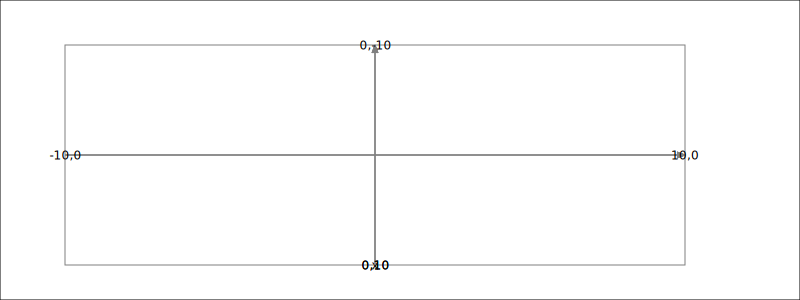

In [42]:
pl.add_axis(arrows=True)
pl.add_text(0, 10, '0,10', font_size=12, font_family='Verdana')
pl.add_text(10, 0, '10,0', font_size=12, font_family='Verdana')
pl.add_text(-10, 0, '-10,0', font_size=12, font_family='Verdana')
pl.add_text(0, -10, '0,-10', font_size=12, font_family='Verdana')
pl.d